----
# Problem 2
----
Nowadays, COVID-19 has taught us that our health is our most important asset, and masks are
now a regular part of our lives. Develop an algorithm to detect masks in images through the
methods learnt in the course. Recall that the region where the object is supposed to be can be
detected through the maximum value of the resulting image template.Consider that several
pre-processing steps are advised to guarantee better results. Export your algorithm into a
python file and program it to receive images and return a meaningful result. Test your algorithm
with images of public spaces containing a person with and without a mask.

---
## **Development stage**
---
To solve this exercise through the methods learned in the course up to the point of this evaluation. Of the methods learned, the Oriented BRIEF and the Rotated FAST (ORB) were implemented, with the Brute Force Matcher. It is necessary to mention how the algorithm to be implemented works, to understand the problems that have to be dealt with in its implementation.

The main objective of ORB is to find the most important features in the objects within an image, through keyPoints and Descriptors. Once we obtain them, we will use a method known as brute force matching to compare them and if they are very similar, classify them as a match. The problem can arise when features are confusing, i.e. features that do not match the pattern we want to detect are matched, which would be a false match. When working with images that contain many elements, such as background environments or other objects that can be confused, the probability of finding a false match increases, and we may not even find matches if the object we want to detect has many differences from our target object.

### **Loading the training images to our workspace.**

In this stage will be developed the implementation code, using preprocessing techniques such as: **filtering**, **morphological operations** and **edge detection**, among others. 

With all the above mentioned, the images used to develop the code will be shown below.

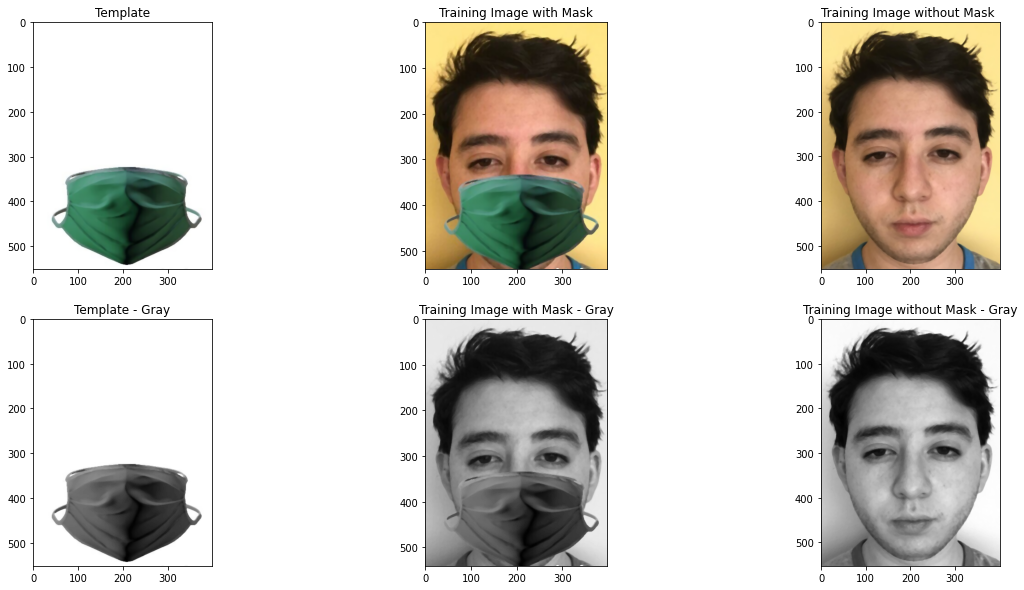

In [ ]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import os, requests
import numpy as np

# Load the template mask image
template_mask = cv2.imread('/content/mask.jpg')
template_mask = cv2.cvtColor(template_mask, cv2.COLOR_BGR2RGB)
#Apply median blur to reduce the image noise
template_mask = cv2.medianBlur(template_mask,5)
template_mask_gray = cv2.cvtColor(template_mask, cv2.COLOR_RGB2GRAY)

# Load the training image for mask
training_image = cv2.imread('/content/mask_image.jpg')
training_image = cv2.cvtColor(training_image, cv2.COLOR_BGR2RGB)
#Apply median blur to reduce the image noise
training_image = cv2.medianBlur(training_image,5)
training_image_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Load the training image for no mask
no_training_image = cv2.imread('/content/no_mask_image.jpg')
no_training_image = cv2.cvtColor(no_training_image, cv2.COLOR_BGR2RGB)
#Apply median blur to reduce the image noise
no_training_image = cv2.medianBlur(no_training_image,5)
no_training_image_gray = cv2.cvtColor(no_training_image, cv2.COLOR_RGB2GRAY)

# Plot the images
plt.figure(figsize=(20, 10))

plt.subplot(231)
plt.title('Template')
plt.imshow(template_mask)

plt.subplot(232)
plt.title('Training Image with Mask')
plt.imshow(training_image)

plt.subplot(233)
plt.title('Training Image without Mask ')
plt.imshow(no_training_image)

plt.subplot(234)
plt.title('Template - Gray')
plt.imshow(template_mask_gray, cmap='gray')

plt.subplot(235)
plt.title('Training Image with Mask - Gray')
plt.imshow(training_image_gray, cmap='gray')

plt.subplot(236)
plt.title('Training Image without Mask - Gray')
plt.imshow(no_training_image_gray, cmap='gray')

plt.show()

### **Pre-processing Stage**

In this part will be obtained the most important components of the image, which in this case would be the edges, for which will be used the CannyEdge detection method. After this, as many remanences as possible will be eliminated and the contours found will be highlighted by means of morphological operations.

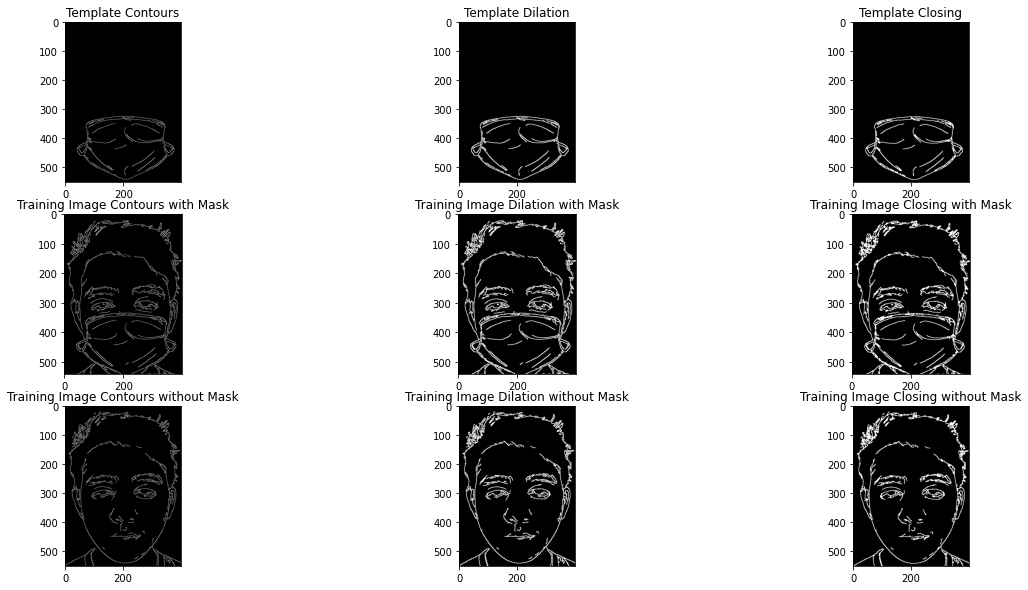

In [ ]:
# Define the morphological transformation kernel to be used
s = np.ones((2,2),np.uint8)

# Use Canny edge detection method
template_mask_contours = cv2.Canny(template_mask, 60, 120)
training_image_contours = cv2.Canny(training_image, 60, 120)
no_training_image_contours = cv2.Canny(no_training_image, 60, 120)
# Apply Dilation to highlight the edges previously found
template_mask_dilation = cv2.dilate(template_mask_contours, s, iterations = 1)
training_image_dilation = cv2.dilate(training_image_contours, s, iterations = 1)
no_training_image_dilation = cv2.dilate(no_training_image_contours, s, iterations = 1)
# Apply Closing to reduce remaining parts
template_mask_closing = cv2.morphologyEx(template_mask_dilation, cv2.MORPH_CLOSE, s,5)
training_image_closing = cv2.morphologyEx(training_image_dilation, cv2.MORPH_CLOSE, s,5)
no_training_image_closing = cv2.morphologyEx(no_training_image_dilation, cv2.MORPH_CLOSE, s,5)

# Plot the images
plt.figure(figsize=(20, 10))

plt.subplot(331)
plt.title('Template Contours')
plt.imshow(template_mask_contours, cmap='gray')

plt.subplot(332)
plt.title('Template Dilation')
plt.imshow(template_mask_dilation, cmap='gray')

plt.subplot(333)
plt.title('Template Closing')
plt.imshow(template_mask_closing, cmap='gray')

plt.subplot(334)
plt.title('Training Image Contours with Mask')
plt.imshow(training_image_contours, cmap='gray')

plt.subplot(335)
plt.title('Training Image Dilation with Mask')
plt.imshow(training_image_dilation, cmap='gray')

plt.subplot(336)
plt.title('Training Image Closing with Mask')
plt.imshow(training_image_closing, cmap='gray')

plt.subplot(337)
plt.title('Training Image Contours without Mask')
plt.imshow(no_training_image_contours, cmap='gray')

plt.subplot(338)
plt.title('Training Image Dilation without Mask')
plt.imshow(no_training_image_dilation, cmap='gray')

plt.subplot(339)
plt.title('Training Image Closing without Mask')
plt.imshow(no_training_image_closing, cmap='gray')

plt.show()

As we can see our pre-processing has highlighted the main features in both the training images and the mask template.

### Processing stage: Detection using ORB

Now that the important features have been highlighted, we will implement ORB to obtain the keypoints.

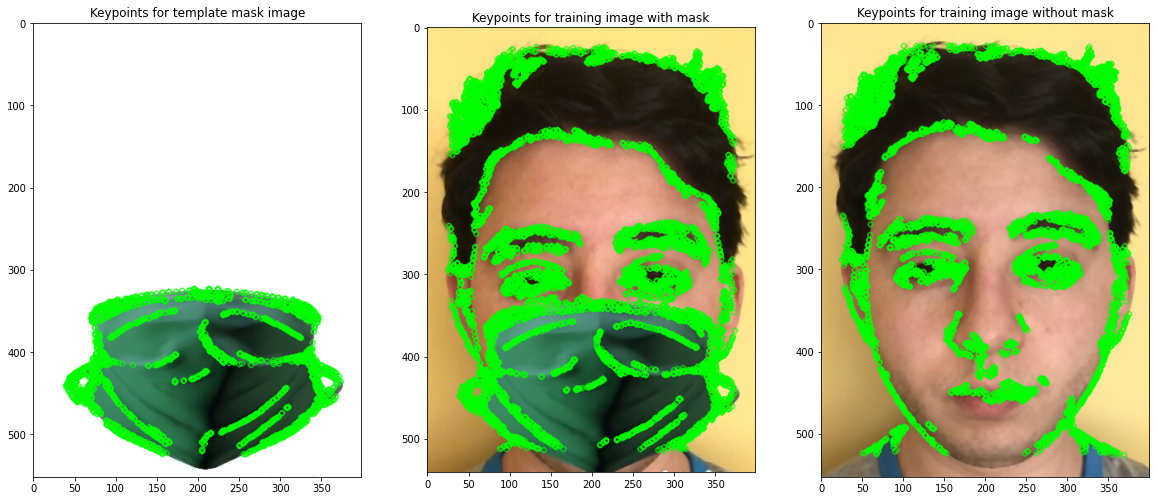

In [ ]:
# Images are copied to avoid overwriting.
keypoints_training_image_draw = np.copy(training_image)
keypoints_no_training_image_draw = np.copy(no_training_image)
keypoints_template_mask_draw = np.copy(template_mask)

# Create the ORB object parameters
orb = cv2.ORB_create(nfeatures=50000, scaleFactor = 1.1, edgeThreshold = 25,  nlevels = 8) 

# Find the keypoints and descriptors for the template mask image
kp_template_mask, dp_template_mask = orb.detectAndCompute(template_mask_contours, None)

# Find the keypoints and descriptors for the training image with mask
kp_training_image, dp_training_image = orb.detectAndCompute(training_image_contours, None)

# Find the keypoints and descriptors for the training image without mask
kp_no_training_image, dp_no_training_image = orb.detectAndCompute(no_training_image_contours, None)


# Draw the keypoints without size or orientation on one copy of the template mask image 
cv2.drawKeypoints(template_mask, kp_template_mask, keypoints_template_mask_draw, color = (0,255,0))

# Draw the keypoints without size or orientation on one copy of the training image with mask
cv2.drawKeypoints(training_image, kp_training_image, keypoints_training_image_draw, color = (0,255,0))

# Draw the keypoints without size or orientation on one copy of the training image without mask
cv2.drawKeypoints(no_training_image, kp_no_training_image, keypoints_no_training_image_draw, color = (0,255,0))

# plot the images
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Keypoints for template mask image')
plt.imshow(keypoints_template_mask_draw)

plt.subplot(132)
plt.title('Keypoints for training image with mask')
plt.imshow(keypoints_training_image_draw)

plt.subplot(133)
plt.title('Keypoints for training image without mask')
plt.imshow(keypoints_no_training_image_draw)
plt.show()

In the images of the upper cell can be seen the keypoints detected in each of the images. Note that there is a very high number of keypoints, this is to increase the probability of detecting them in the mask section, where there are fewer than in other sectors of the image.

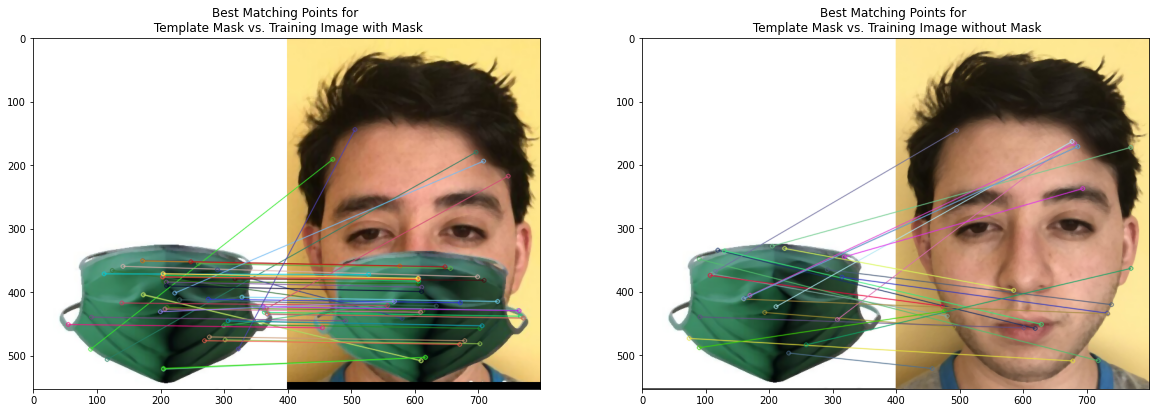

In [ ]:
# Define the accuracy level to accept a match as true
accuracy_percentage = 0.6
# Declare the Brute Force Matcher Object
bf = cv2.BFMatcher()
# Perform the matching between the ORB descriptors of the template mask image and the training image with mask
matches1 = bf.knnMatch(dp_template_mask, dp_training_image,k=2)
# Perform the matching between the ORB descriptors of the template mask image and the training image without mask
matches2 = bf.knnMatch(dp_template_mask, dp_no_training_image,k=2)


good1 = []
good2 = []

for m,n in matches1:
    if m.distance < accuracy_percentage*n.distance:
        good1.append([m])
        
for m,n in matches2:
    if m.distance < accuracy_percentage*n.distance:
        good2.append([m])

# Connect the keypoints in the template mask image with their best matching keypoints in the training image with mask
result1 = cv2.drawMatchesKnn(template_mask, kp_template_mask, training_image, kp_training_image, good1, None, flags = 2)
# Connect the keypoints in the template mask image with their best matching keypoints in the training image without mask
result2 = cv2.drawMatchesKnn(template_mask, kp_template_mask, no_training_image, kp_no_training_image, good2, None, flags = 2)

# Plot the results
plt.figure(figsize=(20, 10))

# Display the best matching points

plt.subplot(121)
plt.title('Best Matching Points for \n Template Mask vs. Training Image with Mask')
plt.imshow(result1)

plt.subplot(122)
plt.title('Best Matching Points for \n Template Mask vs. Training Image without Mask')
plt.imshow(result2)

As we can see in the training image with mask we have a considerable number of matches, on the other hand, in the training image without mask we have few matches except for some false matches.

In [ ]:
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected in the template mask Image: ", len(kp_template_mask))

# Print the number of keypoints detected in the query image
print("\nNumber of Keypoints Detected in the training Image with mask: ", len(kp_training_image))

# Print the number of keypoints detected in the query image
print("\nNumber of Keypoints Detected in the training Image without mask: ", len(kp_no_training_image))

# Print total number of matching points between the training and query images
print("\nNumber of Good Matching Keypoints Between the template and the training image with mask: ", len(good1))

# Print total number of matching points between the training and query images
print("\nNumber of Good Matching Keypoints Between the template and the training image without mask: ", len(good2))

Number of Keypoints Detected in the template mask Image:  2737

Number of Keypoints Detected in the training Image with mask:  8284

Number of Keypoints Detected in the training Image without mask:  6509

Number of Good Matching Keypoints Between the template and the training image with mask:  48

Number of Good Matching Keypoints Between the template and the training image without mask:  23


With the results obtained we can think of a good metric as a minimum number of matching points, in this case we see that the 70% of the result obtained with the training image could be a good decision parameter, this is 34. On the other hand, let's look at 23 as the maximum number of matches allowed to still be considered a good result. This is because when working with ORB and the Brute Force Matcher we will always have confused keypoints.

---
## Generalization stage
---

In this stage our objective will be to generalise the code used before to work with a dataset. 

### Loading the dataset images to our workspace

To begin, the images of people wearing masks and the images of people without masks, will be uploaded and displayed.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

%matplotlib inline

# Read the images
people_masks = []
people_no_masks = []
people_masks_names = []
people_no_masks_names = []
people_masks_gray = []
people_no_masks_gray = []
i=1

for image_name1, image_name2 in zip(os.listdir('mask/'),os.listdir('no_mask/')):
  people_masks_names.append(image_name1)
  people_no_masks_names.append(image_name2)
  image1 = cv2.imread('mask/'+image_name1)
  image2 = cv2.imread('no_mask/'+image_name2)
  image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
  image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
  image1 = cv2.medianBlur(image1,5)
  image2 = cv2.medianBlur(image2,5)
  people_masks.append(image1)
  people_no_masks.append(image2)
  image1_gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
  image2_gray = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
  people_masks_gray.append(image1_gray)
  people_no_masks_gray.append(image2_gray)

people_DB = people_masks+people_no_masks
people_DB_names = people_masks_names+people_no_masks_names

Display the images of people wearing masks.


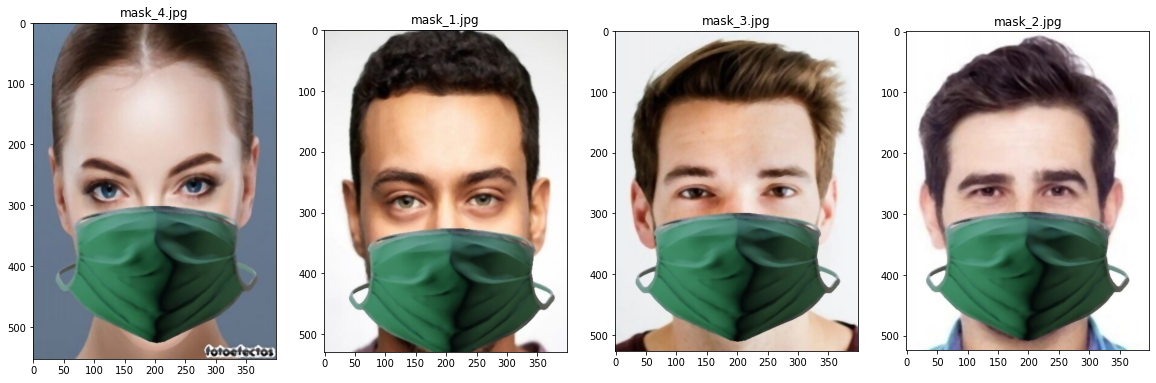

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(4):
  plt.subplot(1, 4, i+1)
  image = people_masks[i]
  name = people_masks_names[i]
  plt.imshow(image, 'gray')
  plt.title(name)

Display the images of people without wearing masks.


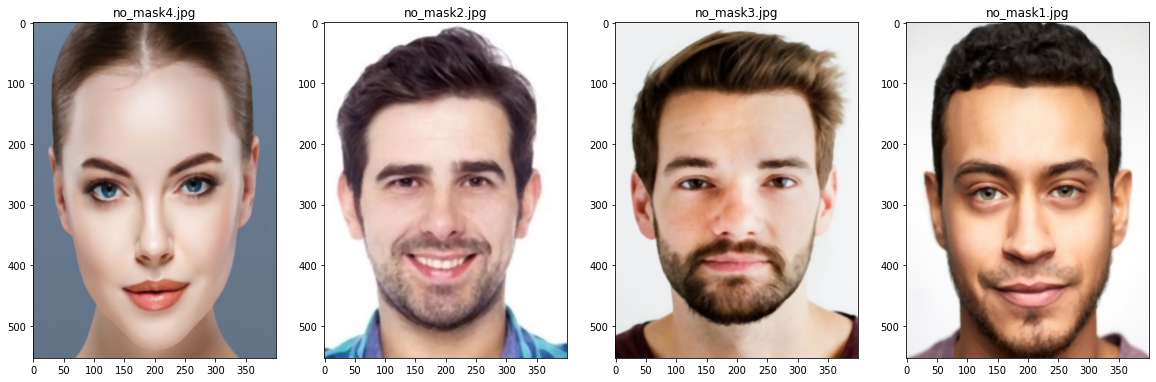

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(4):
  plt.subplot(1, 4, i+1)
  image = people_no_masks[i]
  name = people_no_masks_names[i]
  plt.imshow(image, 'gray')
  plt.title(name)

### Pre-processing dataset

Now will be applied the pre-processing previously performed for the training images to the complete dataset.

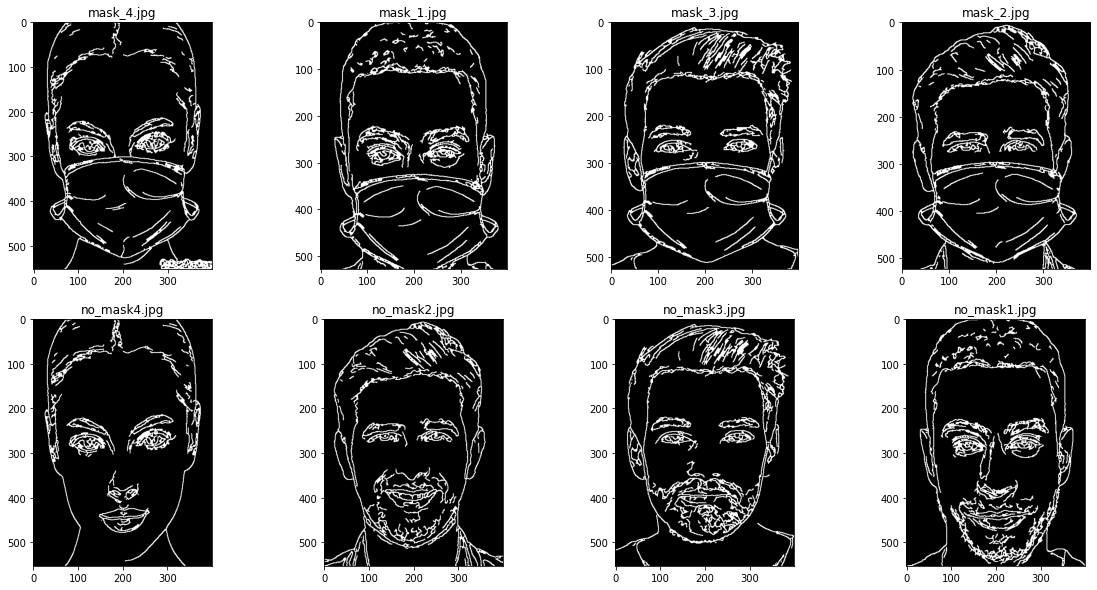

In [ ]:
pre_processed_images = []

# Define the morphological transformation kernel to be used
s = np.ones((2,2),np.uint8)

for image in people_DB:
  # Use Canny edge detection method
  image = cv2.Canny(image, 60, 120)
  # Apply Dilation to highlight the edges previously found
  image = cv2.dilate(image, s, iterations = 1)
  # Apply Closing to reduce remaining parts
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, s, 5)
  

  pre_processed_images.append(image)

plt.figure(figsize=(20, 10))
for i in range(8):
  plt.subplot(2, 4, i+1)
  image = pre_processed_images[i]
  name = people_DB_names[i]
  plt.imshow(image, 'gray')
  plt.title(name)

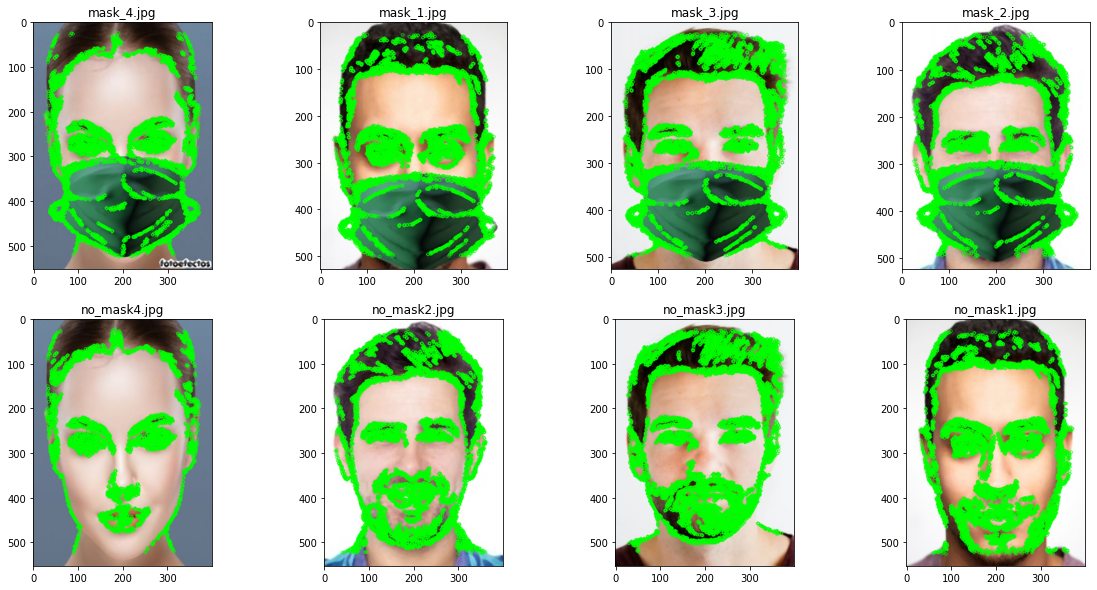

In [ ]:
keypoints_image_draw = []
kp_list = []
dp_list = []

for pre_processed, image in zip(pre_processed_images, people_DB):
  draw = np.copy(image)
  # Create the ORB object parameters  
  orb = cv2.ORB_create(nfeatures=50000, scaleFactor = 1.1, edgeThreshold = 25,  nlevels = 8) 
  # Find the keypoints and descriptors for the template mask image
  kp, dp = orb.detectAndCompute(pre_processed, None)
  # Draw the keypoints without size or orientation on one copy of the template mask image 
  cv2.drawKeypoints(image, kp, draw, color = (0,255,0))
  keypoints_image_draw.append(draw)
  kp_list.append(kp)
  dp_list.append(dp)

plt.figure(figsize=(20, 10))
for i in range(8):
  plt.subplot(2, 4, i+1)
  image = keypoints_image_draw[i]
  name = people_DB_names[i]
  plt.imshow(image, 'gray')
  plt.title(name)

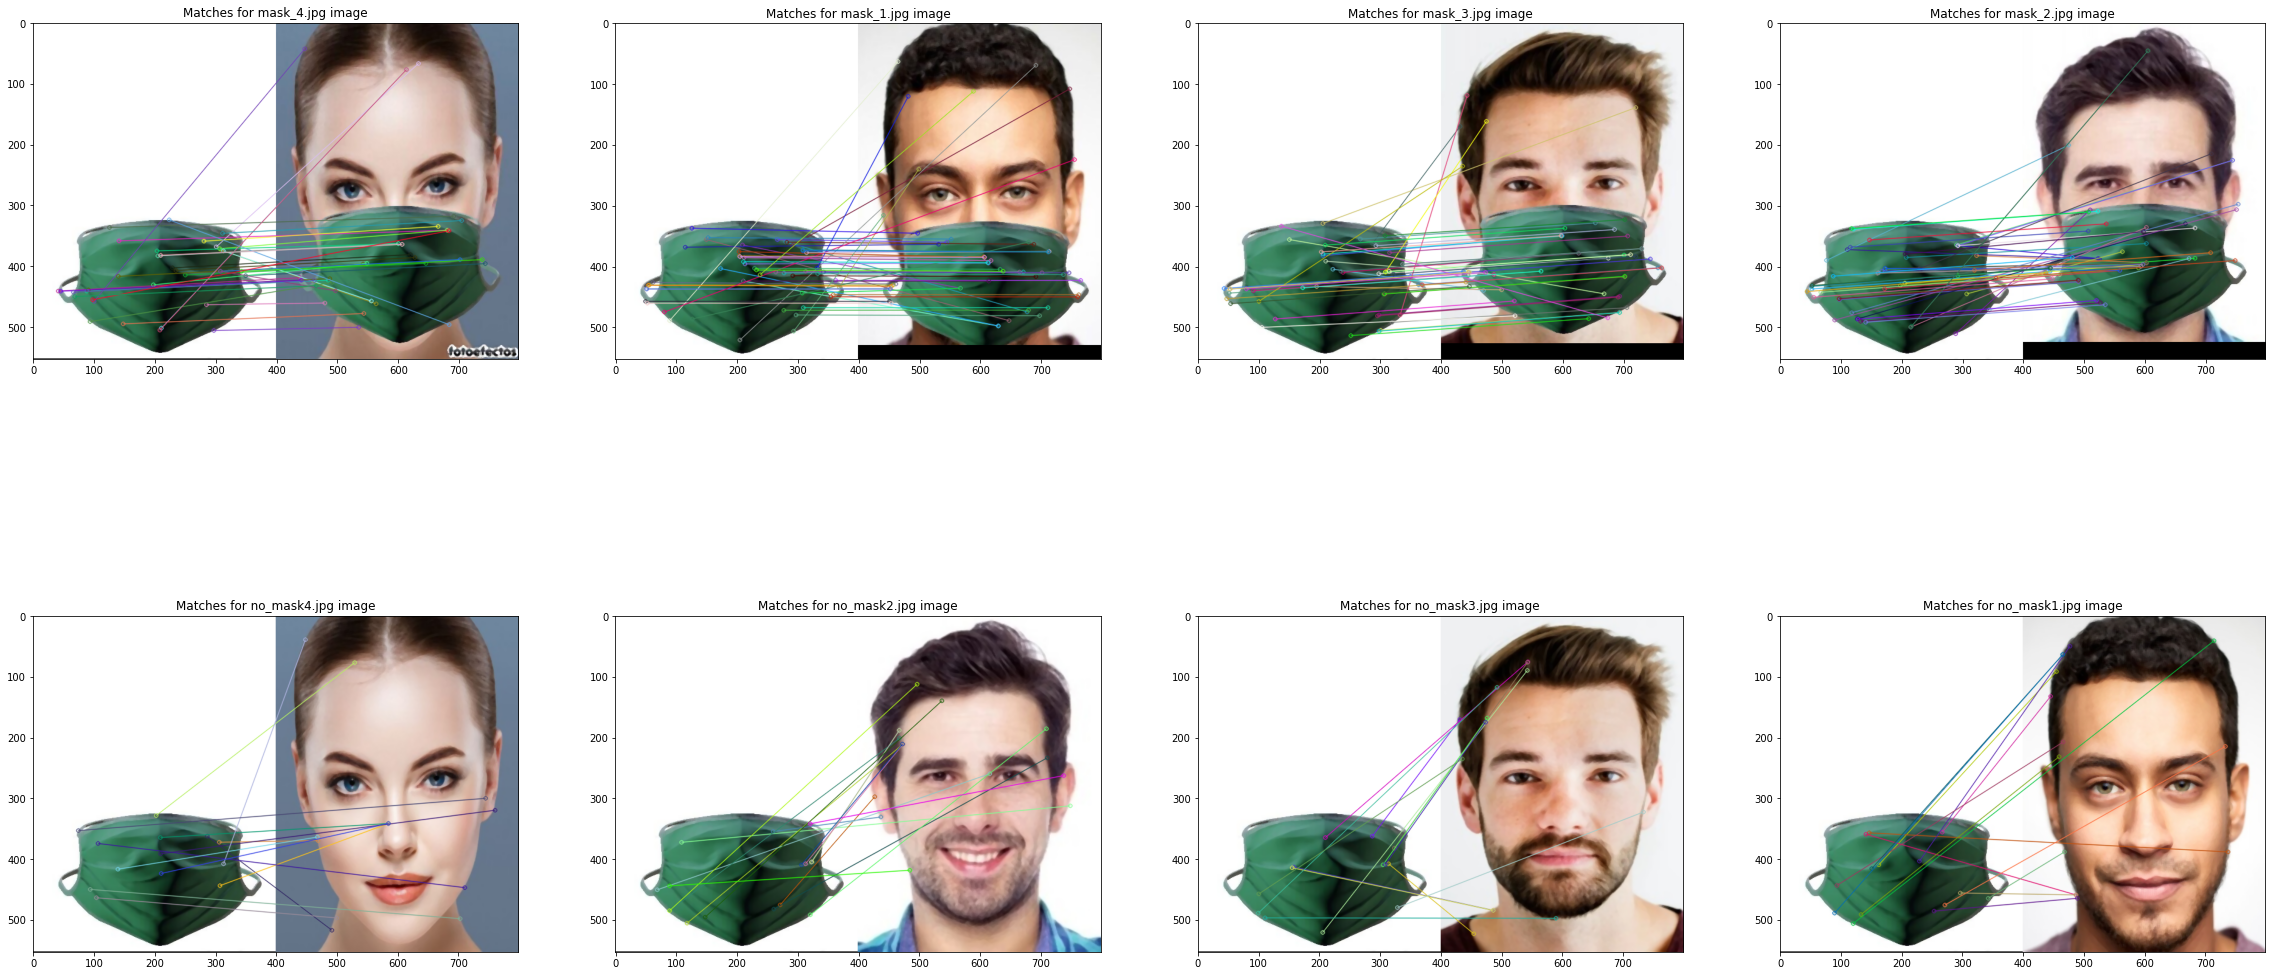

In [ ]:
# Define the accuracy level to accept a match as true
accuracy_percentage = 0.6
# Declare the Brute Force Matcher Object
bf = cv2.BFMatcher()

resulting_images = []
good_matches_list = []


for kp, dp, image in zip(kp_list, dp_list, people_DB):
  # Perform the matching between the ORB descriptors of the template mask image and the training image with mask
  matches = bf.knnMatch(dp_template_mask, dp, k=2)
  
  good = []
  for m,n in matches:
    if m.distance < accuracy_percentage*n.distance:
        good.append([m])

  good_matches_list.append(good)

  # Connect the keypoints in the template mask image with their best matching keypoints in the training image with mask
  result = cv2.drawMatchesKnn(template_mask, kp_template_mask, image, kp, good, None, flags = 2)
  resulting_images.append(result)

plt.figure(figsize=(40, 20))  
for i in range(8):
  plt.subplot(2, 4, i+1)
  image = resulting_images[i]
  name = people_DB_names[i]
  plt.imshow(image, 'gray')
  plt.title(f'Matches for {name} image')

In [ ]:
mask = []
for match, i in zip(good_matches_list, range(8)):
  name = people_DB_names[i]
  good_matches = len(match)
  print(f'-{good_matches} good matching points.')
  if (good_matches>34):
    mask.append(True) 
  else:
    mask.append(False)

A mask is detected in the image mask_4.jpg with 37 good matching points.
A mask is detected in the image mask_1.jpg with 52 good matching points.
A mask is detected in the image mask_3.jpg with 48 good matching points.
A mask is detected in the image mask_2.jpg with 49 good matching points.
A mask is detected in the image no_mask4.jpg with 13 good matching points.
A mask is detected in the image no_mask2.jpg with 16 good matching points.
A mask is detected in the image no_mask3.jpg with 13 good matching points.
A mask is detected in the image no_mask1.jpg with 14 good matching points.


Based on the decision taken on the basis of the metric of a minimum of 34 keypoints to consider that a mask has been detected in the image, the image will be enclosed in a green border if it corresponds to a mask detection and a red border if it corresponds to no mask being detected.

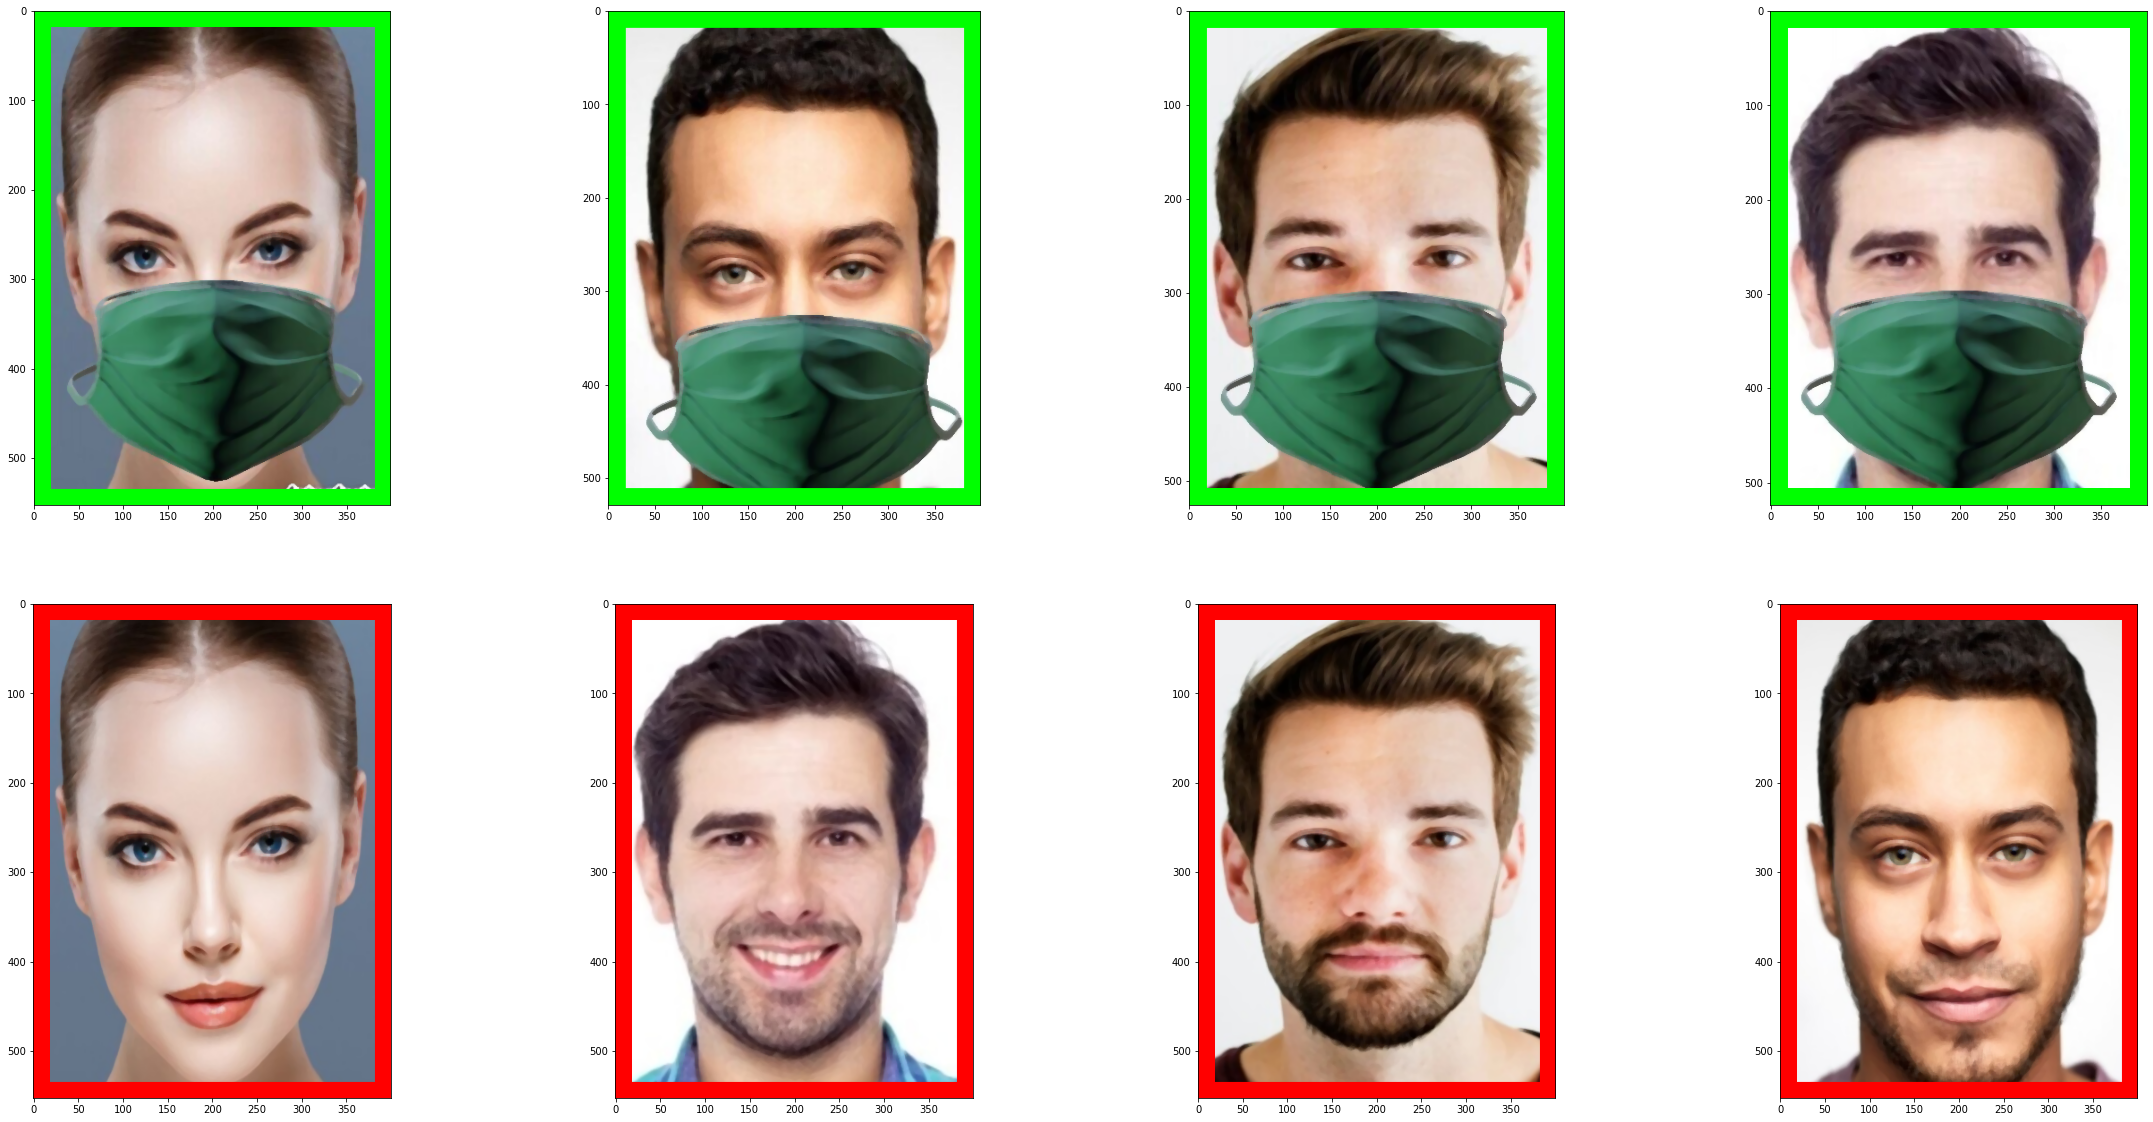

In [ ]:
final_images = []

for image,m in zip(people_DB,mask):
  final_image = np.copy(image)
  w = final_image.shape[0]
  h = final_image.shape[1]
  
  if (m):
    cv2.rectangle(final_image, (0, 0), (h, w), (0, 255, 0), 35)
  else:
    cv2.rectangle(final_image, (0, 0), (h, w), (255, 0, 0), 35)
  
  final_images.append(final_image)

plt.figure(figsize=(40, 20))  
for i in range(8):
  plt.subplot(2, 4, i+1)
  image = final_images[i]
  plt.imshow(image, 'gray')